In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider   # <-- thêm dòng này


In [ ]:
path_folder = "D:/OneDrive/Ca nhan/Study/Hoc thac si/GenAI - Dai hoc Bach khoa/0. Bo sung kien thuc/5. Thi giac may tinh (IT5409 - Nguyen Thi Oanh)/Bai tap nhom/Proj1.2/Proj1.2/"

In [ ]:
# --- 1. Hàm phân loại
def classify_img(img):
    # a. Kiểm tra ảnh tối (Bright < 30)
    if np.mean(img) < 30: return "Dark"

    # b. Kiểm tra nhiễu muối tiêu (Salt > 8)
    if np.mean(cv2.absdiff(img, cv2.medianBlur(img, 3))) > 8: return "Salt_Pepper"

    # c. Kiểm tra nhiễu sọc (1D FFT > 50)
    proj = np.mean(img, axis=0) # Chiếu dọc
    spec = np.abs(np.fft.fft(proj - np.mean(proj)))[1:len(proj)//2]
    if np.max(spec) / (np.mean(spec) + 1e-9) > 50: return "Sinus"

    # d. Mặc định
    return "Standard"

# ====== 1) Image Enhancement (Ch.3) ======
def enhance(img):
    # CLAHE giúp tăng tương phản trên nền nhiễu hạt
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    eq = clahe.apply(img)
    img = cv2.GaussianBlur(eq, (3,3), 0)
    return img

# ====== 2) Segmentation (Ch.5): Otsu threshold ======
def binarize(img_gray):
    _, th = cv2.threshold(img_gray, 0, 255,
                          cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # đảo ngưỡng nếu viền (nền) đang trắng
    border = np.concatenate([th[0,:], th[-1,:], th[:,0], th[:,-1]])
    if np.mean(border) > 127:
        th = cv2.bitwise_not(th)
    return th

# ====== 3) Morphology (Ch.5) ======
def morph(binary):
    # Mở (OPEN) nhẹ để bỏ nhiễu nhỏ
    k_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, k_open, iterations=1)

    # Đóng (CLOSE) mạnh hơn để liền khe đen mảnh giữa hạt
    k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, k_close, iterations=2)

    return closed


# ====== 4) Split touching grains: Distance Transform + Watershed (Ch.5) ======
def split_watershed(binary, color_img):
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    sure_bg = cv2.dilate(binary, k, iterations=2)

    dist = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
    dist_norm = cv2.normalize(dist, None, 0, 1.0, cv2.NORM_MINMAX)
    # Ngưỡng trên distance map (tham số cần tinh chỉnh nếu over/under-split)
    _, sure_fg = cv2.threshold(dist_norm, 0.35, 1.0, cv2.THRESH_BINARY)
    sure_fg = (sure_fg*255).astype(np.uint8)

    unknown = cv2.subtract(sure_bg, sure_fg)
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    markers = cv2.watershed(color_img.copy(), markers)
    return markers

def gaussian_notch_mask(img, D0=2, centers=[(0,8), (0,-8)]):
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Biến đổi Fourier
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    # Hàm tạo mặt nạ Gaussian Notch Reject Filter
    def gaussian_notch_mask(shape, centers, D0=10):
        h, w = shape
        u = np.arange(h)
        v = np.arange(w)
        U, V = np.meshgrid(u - h//2, v - w//2, indexing='ij')
        mask = np.ones((h, w), dtype=np.float32)

        for (cy, cx) in centers:
            Dk = np.sqrt((U - cy)**2 + (V - cx)**2)
            Dk_conj = np.sqrt((U + cy)**2 + (V + cx)**2)
            mask *= (1 - np.exp(-0.5 * (Dk**2 / D0**2))) * (1 - np.exp(-0.5 * (Dk_conj**2 / D0**2)))
        return mask

    # Tạo mask cho đúng vị trí nhiễu
    mask = gaussian_notch_mask(img.shape, centers, D0=D0)

    # Áp dụng mặt nạ và biến đổi ngược
    fshift_filtered = fshift * mask
    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    return img_back

def show_images(img_list, cmap='gray', figsize=(15, 5)):
    """
    Hiển thị danh sách ảnh kèm tiêu đề.

    Tham số:
        img_list: list chứa các phần tử dạng [image, title]
        cmap: bảng màu hiển thị (mặc định 'gray')
        figsize: kích thước toàn bộ figure (mặc định (15,5))
    """
    n = len(img_list)
    if n == 0:
        print("Danh sách ảnh trống!")
        return

    plt.figure(figsize=figsize, facecolor='white')

    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(img_list, 1):
        plt.subplot(1, n, i)
        # xử lý ảnh phức nếu có (như phổ Fourier)
        if np.iscomplexobj(img):
            img = np.log1p(np.abs(img))
        plt.imshow(img, cmap=cmap)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()




In [ ]:
def binarize_2(img_gray, shift=-30, blur_sigma=1.2, fill_holes=True):
    """
    Binarization với điều chỉnh ngưỡng cắt để giữ tối đa hạt trắng.
    - shift: giá trị dịch ngưỡng Otsu (âm => giữ nhiều vùng sáng hơn)
    - blur_sigma: làm mượt nhẹ để tránh tách viền
    - fill_holes: có lấp lỗ trong hạt hay không
    """

    # Làm mượt nhẹ để Otsu không bắt biên rìa
    img_blur = cv2.GaussianBlur(img_gray, (0, 0), blur_sigma)

    # Tính ngưỡng Otsu
    val, _ = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    new_thresh = max(0, min(255, val + shift))  # điều chỉnh ngưỡng

    # Áp dụng ngưỡng mới
    _, th = cv2.threshold(img_blur, new_thresh, 255, cv2.THRESH_BINARY)

    # Đảo ngưỡng nếu viền (nền) đang trắng
    border = np.concatenate([th[0,:], th[-1,:], th[:,0], th[:,-1]])
    if np.mean(border) > 127:
        th = cv2.bitwise_not(th)

    # Lấp lỗ nhỏ bên trong hạt nếu cần
    if fill_holes:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=2)

    return th

def split_watershed(binary, color_img,
                    erode_ksize=7, erode_iter=1,     # ↓ tăng nếu còn tách đôi
                    bg_dilate_iter=1):
    # Chuẩn hoá
    if binary.dtype != np.uint8:
        binary = (binary > 0).astype(np.uint8)*255
    if color_img.ndim == 2:
        color_img = cv2.cvtColor(color_img, cv2.COLOR_GRAY2BGR)
    color_img = color_img.astype(np.uint8)

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (erode_ksize, erode_ksize))

    # >>> seed bằng erosion thay vì threshold distance <<<
    sure_fg = cv2.erode(binary, k, iterations=erode_iter)      # lõi hạt → 1 seed/hạt

    sure_bg = cv2.dilate(binary, k, iterations=bg_dilate_iter)  # nền nở nhẹ để có "unknown"
    unknown = cv2.subtract(sure_bg, sure_fg)

    # markers int32
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers.astype(np.int32) + 1
    markers[unknown == 255] = 0

    markers = cv2.watershed(color_img, markers)
    return markers



In [ ]:
def enhance_contrast(img, bg_ksize=81, clahe_clip=2.0, clahe_grid=(8,8)):
  # 1) về xám
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim==3 else img.copy()

    # 2) Flat-field: ước lượng nền bằng blur lớn rồi trừ đi
    #   (medianBlur ổn với chi tiết “hạt gạo” mảnh)
    bg = cv2.medianBlur(gray, bg_ksize)        # thử 81 / 101 tùy kích thước ảnh
    flat = cv2.normalize(gray.astype(np.float32) - bg.astype(np.float32),
                         None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # 3) CLAHE để kéo tương phản cục bộ (giúp vùng trên sáng lên)
    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=clahe_grid)
    out = clahe.apply(flat)

    # 4) Làm mượt rất nhẹ để đồng nhất độ sáng bên trong hạt
    out = cv2.GaussianBlur(out, (3,3), 0.5)
    return out

    return out

<Figure size 1500x500 with 0 Axes>

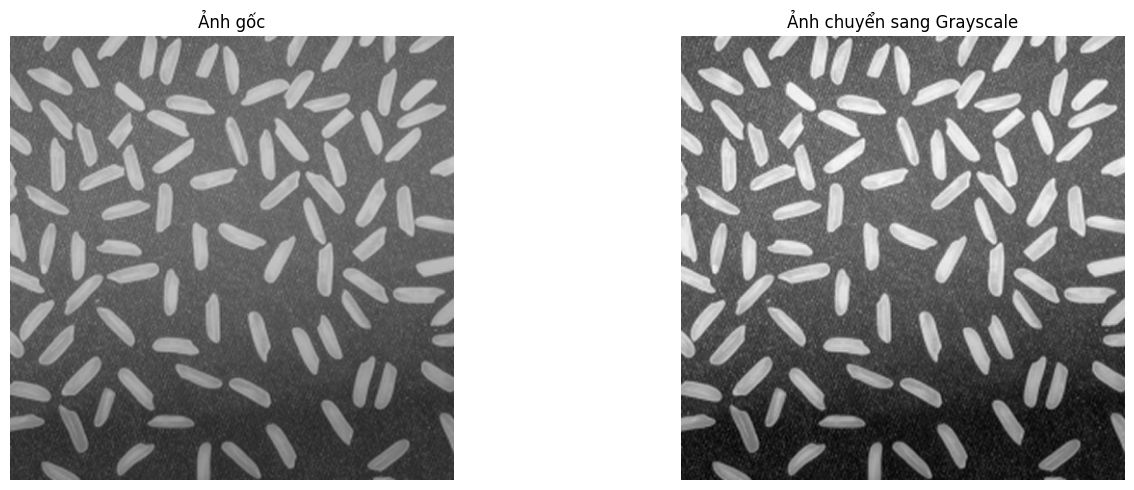

In [ ]:
img_name = "1_wIXlvBeAFtNVgJd49VObgQ.png"
raw = cv2.imdecode(np.fromfile(path_folder + img_name, dtype=np.uint8),
                   cv2.IMREAD_COLOR)
gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)

show_images([
    [raw, "Ảnh gốc"],
    [gray, "Ảnh chuyển sang Grayscale"]
])

img = gray

<Figure size 1500x500 with 0 Axes>

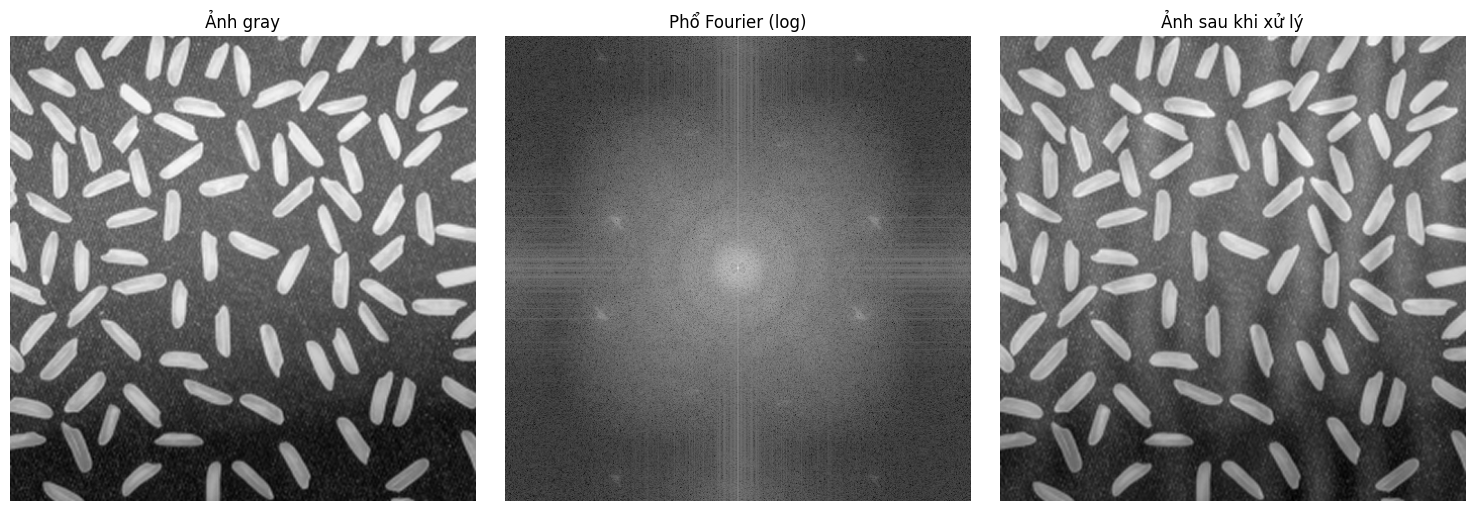

In [ ]:
# --- Demo hiển thị ---
img_filtered = gaussian_notch_mask(img)

# Hiển thị 3 ảnh: Gốc - Phổ - Sau xử lý
f = np.fft.fftshift(np.fft.fft2(img))

show_images([
    [img, "Ảnh gray"],
    [np.log1p(np.abs(f)), "Phổ Fourier (log)"],
    [img_filtered, "Ảnh sau khi xử lý"]
])


<Figure size 1500x500 with 0 Axes>

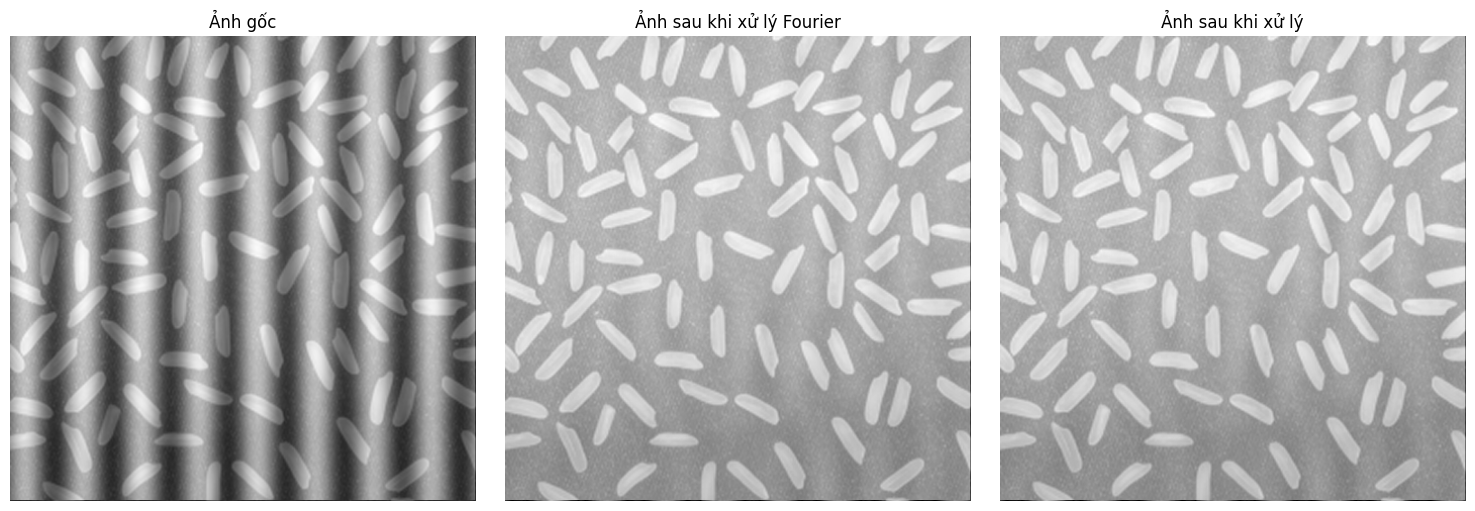

In [ ]:
enhanced = enhance(img)

show_images([
    [raw, "Ảnh gốc"],
    [img_filtered, "Ảnh sau khi xử lý Fourier"],
    [enhanced, "Ảnh sau khi xử lý"]
])

img = enhanced

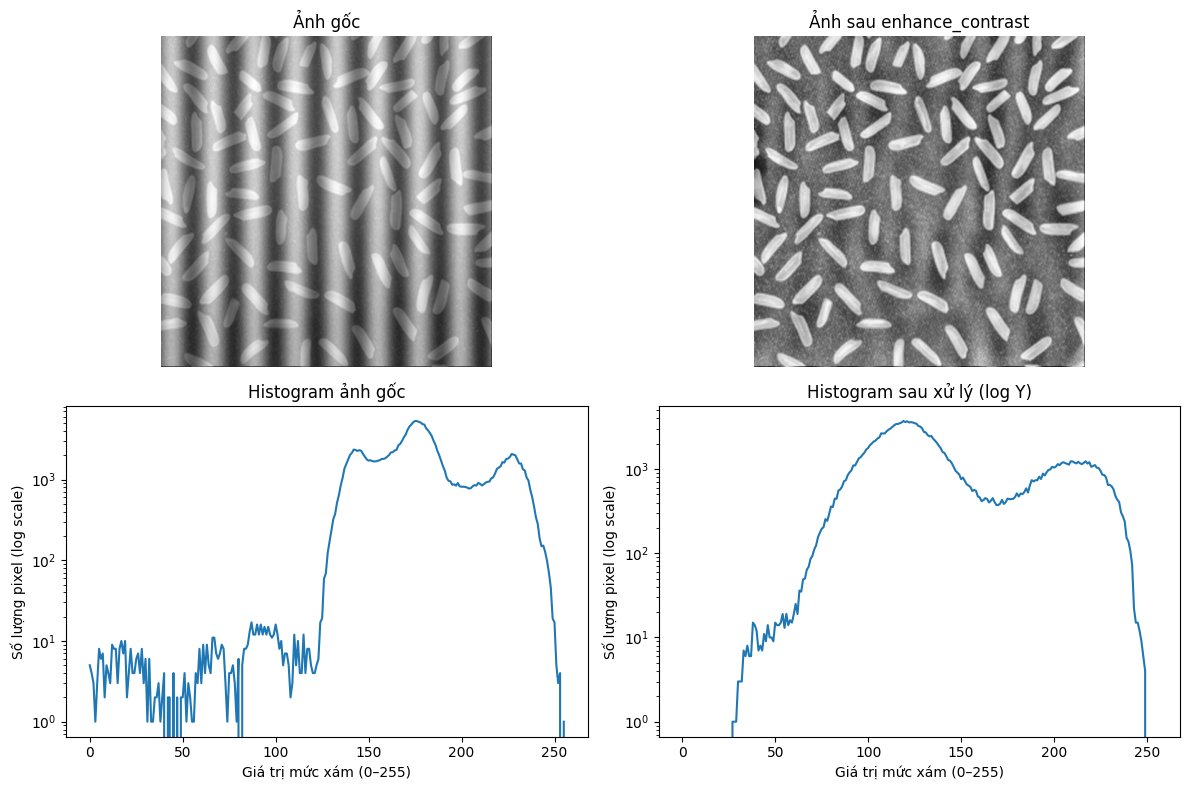

In [ ]:

enh = enhance_contrast(img)

# --- Tính histogram ---
hist_ori = cv2.calcHist([img], [0], None, [256], [0,256]).flatten()
hist_enh = cv2.calcHist([enh], [0], None, [256], [0,256]).flatten()

# --- Hiển thị ---
plt.figure(figsize=(12, 8))

plt.subplot(2,2,1)
plt.imshow(raw, cmap='gray')
plt.title("Ảnh gốc")
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(enh, cmap='gray')
plt.title("Ảnh sau enhance_contrast")
plt.axis('off')

plt.subplot(2,2,3)
plt.plot(hist_ori)
plt.title("Histogram ảnh gốc")
plt.xlabel("Giá trị mức xám (0–255)")
plt.ylabel("Số lượng pixel (log scale)")
plt.yscale('log')

plt.subplot(2,2,4)
plt.plot(hist_enh)
plt.title("Histogram sau xử lý (log Y)")
plt.xlabel("Giá trị mức xám (0–255)")
plt.ylabel("Số lượng pixel (log scale)")
plt.yscale('log')

plt.tight_layout()
plt.show()

img = enh


<Figure size 1500x500 with 0 Axes>

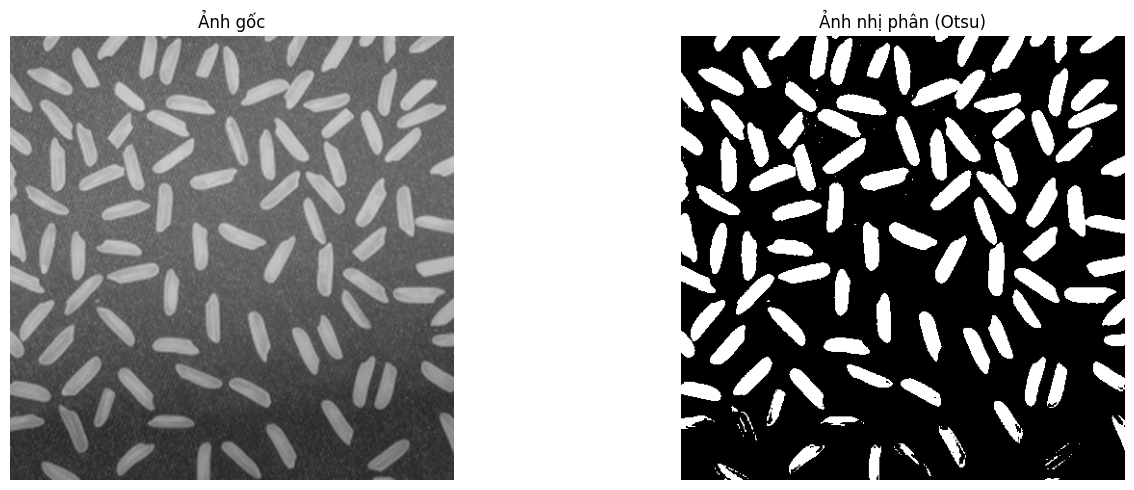

In [ ]:
binary = binarize(img)
# binary = binarize(enh)

show_images([
    [raw, "Ảnh gốc"],
    [binary, "Ảnh nhị phân (Otsu)"]
])

img = binary

<Figure size 1500x500 with 0 Axes>

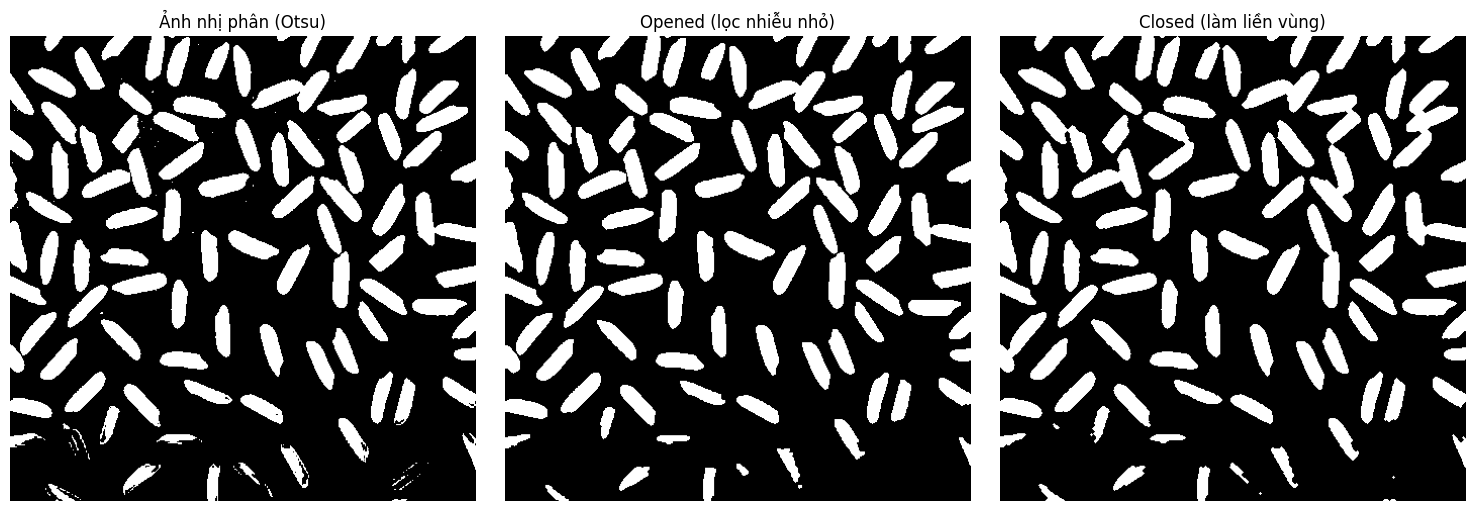

In [ ]:
k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4,4))
opened_vis = cv2.morphologyEx(binary, cv2.MORPH_OPEN, k, iterations=1)
morphed = morph(img)

# ====== Hiển thị ======

show_images([
    [binary, "Ảnh nhị phân (Otsu)"],
    [opened_vis, "Opened (lọc nhiễu nhỏ)"],
    [morphed, "Closed (làm liền vùng)"]
])

img = morphed


<Figure size 1500x500 with 0 Axes>

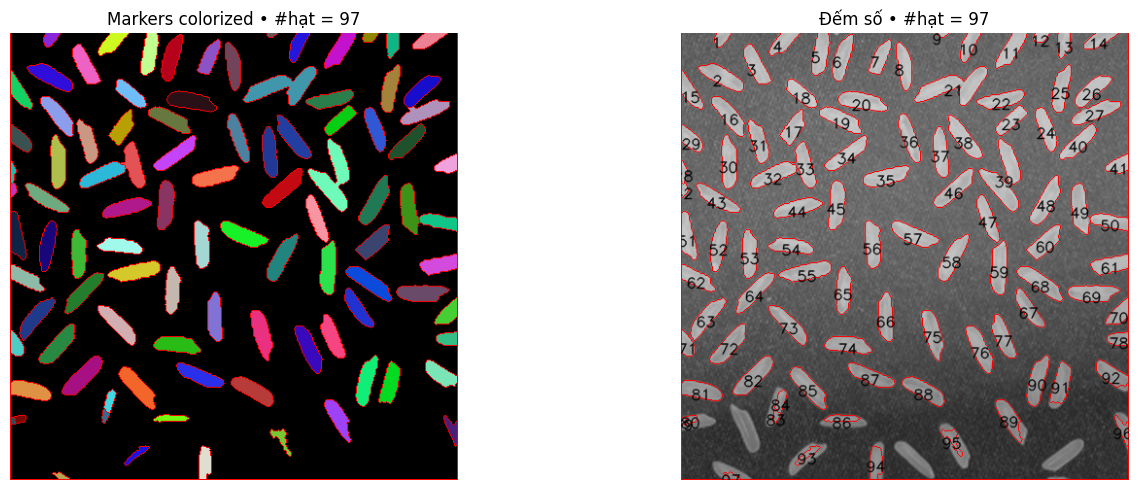

In [ ]:
# 1) Gọi watershed
markers = split_watershed(binary=img, color_img=raw)

# 2) Ảnh overlay biên (ranh giới = -1) lên ảnh gốc
overlay = cv2.cvtColor(raw.copy(), cv2.COLOR_BGR2RGB)
overlay[markers == -1] = [255, 0, 0]   # ranh giới tô đỏ

# 3) Tạo ảnh gán màu cho từng nhãn hạt (>=2)
label_vis = np.zeros_like(overlay)     # RGB
grain_labels = [lab for lab in np.unique(markers) if lab > 1]

# Tạo bảng màu ngẫu nhiên nhưng cố định để tái lập
rng = np.random.default_rng(42)
colors = {lab: rng.integers(0, 256, size=3, dtype=np.uint8) for lab in grain_labels}

for lab in grain_labels:
    label_vis[markers == lab] = colors[lab]
# tô ranh giới đỏ cho dễ nhìn
label_vis[markers == -1] = [255, 0, 0]

count = len(grain_labels)


# Hiển thị số
markers = split_watershed(binary=morphed, color_img=raw)

# Tô ranh giới (pixels có giá trị -1)
overlay[markers == -1] = [255, 0, 0]

# Lấy danh sách nhãn hạt (bỏ nền và biên)
grain_labels = [lab for lab in np.unique(markers) if lab > 1]

# Lấy tâm (centroid) của mỗi hạt
centroids = []
for lab in grain_labels:
    ys, xs = np.where(markers == lab)
    if len(xs) > 0 and len(ys) > 0:
        cx, cy = int(np.mean(xs)), int(np.mean(ys))
        centroids.append((lab, cx, cy))

# 5Sắp xếp thứ tự: từ trên xuống, trái sang phải (y trước, rồi x)
centroids_sorted = sorted(centroids, key=lambda c: (c[2] // 50, c[1]))

# Vẽ số thứ tự
for idx, (lab, cx, cy) in enumerate(centroids_sorted, start=1):
    cv2.putText(overlay, str(idx), (cx-10, cy+10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)

# 4) Hiển thị
show_images([
    [label_vis, f"Markers colorized • #hạt = {count}"],
    [overlay, f"Đếm số • #hạt = {count}"]
])


In [ ]:
import cv2
import numpy as np
import os

# --- 1. CẤU HÌNH ĐƯỜNG DẪN & NGƯỠNG ---
path_folder = "D:/OneDrive/Ca nhan/Study/Hoc thac si/GenAI - Dai hoc Bach khoa/0. Bo sung kien thuc/5. Thi giac may tinh (IT5409 - Nguyen Thi Oanh)/Bai tap nhom/Proj1.2/Proj1.2/"

# Các ngưỡng đã chốt
TH_BRIGHT = 30.0
TH_SALT = 8.0
TH_FFT = 50.0

def calculate_metrics(img_path):
    # Đọc ảnh
    stream = open(img_path, "rb")
    bytes = bytearray(stream.read())
    numpyarray = np.asarray(bytes, dtype=np.uint8)
    img = cv2.imdecode(numpyarray, cv2.IMREAD_GRAYSCALE)
    stream.close()

    if img is None: return None

    # --- THAM SỐ 1: BRIGHTNESS (Độ sáng TB) ---
    bright = np.mean(img)

    # --- THAM SỐ 2: SALT SCORE (Nhiễu muối tiêu) ---
    # Lấy ảnh gốc trừ đi ảnh đã lọc Median để tìm ra các hạt nhiễu
    denoised = cv2.medianBlur(img, 3)
    diff = cv2.absdiff(img, denoised)
    salt = np.mean(diff)

    # --- THAM SỐ 3: 1D FFT SCORE (Phát hiện sọc/Sinus) ---
    # Ép ảnh thành 1 đường tín hiệu (trung bình cột)
    proj = np.mean(img, axis=0)

    # Biến đổi Fourier trên đường tín hiệu này
    proj_detrend = proj - np.mean(proj) # Loại bỏ thành phần DC
    spectrum = np.abs(np.fft.fft(proj_detrend))

    # Lấy nửa phổ (bỏ tần số 0)
    valid_spec = spectrum[1:len(spectrum)//2]

    # Tính tỷ lệ: Đỉnh cao nhất / Trung bình nền
    if len(valid_spec) > 0:
        fft_score = np.max(valid_spec) / (np.mean(valid_spec) + 1e-9)
    else:
        fft_score = 0

    return bright, salt, fft_score

def classify_image(bright, salt, fft_score):
    # Logic ưu tiên theo yêu cầu
    if bright < TH_BRIGHT:
        return "Ảnh tối (Dark)"

    # Ưu tiên check nhiễu sọc và muối tiêu
    if fft_score > TH_FFT:
        return "Nhiễu sọc (Sinus)"

    if salt > TH_SALT:
        return "Nhiễu muối tiêu (Salt_Pepper)"

    # Còn lại
    return "Ảnh chuẩn (Standard)"

# --- CHẠY VÀ IN BẢNG KẾT QUẢ ---
print(f"Đang xử lý thư mục: {path_folder}\n")

# Header bảng
print(f"{'TÊN FILE':<55} | {'BRIGHT':<8} | {'SALT':<8} | {'1D FFT':<8} | {'-> KẾT LUẬN'}")
print("-" * 110)

valid_extensions = ['.png', '.jpg', '.jpeg']
files = [f for f in os.listdir(path_folder) if os.path.splitext(f)[1].lower() in valid_extensions]
files.sort()

for file_name in files:
    full_path = os.path.join(path_folder, file_name)
    metrics = calculate_metrics(full_path)

    if metrics:
        b, s, f = metrics
        # Lấy kết luận dựa trên thông số
        result = classify_image(b, s, f)

        # In ra màn hình
        print(f"{file_name:<55} | {b:<8.2f} | {s:<8.2f} | {f:<8.2f} | {result}")
    else:
        print(f"{file_name:<55} | ERROR READING FILE")

Đang xử lý thư mục: D:/OneDrive/Ca nhan/Study/Hoc thac si/GenAI - Dai hoc Bach khoa/0. Bo sung kien thuc/5. Thi giac may tinh (IT5409 - Nguyen Thi Oanh)/Bai tap nhom/Proj1.2/Proj1.2/

TÊN FILE                                                | BRIGHT   | SALT     | 1D FFT   | -> KẾT LUẬN
--------------------------------------------------------------------------------------------------------------
1_wIXlvBeAFtNVgJd49VObgQ.png                            | 110.78   | 1.66     | 16.00    | Ảnh chuẩn (Standard)
1_wIXlvBeAFtNVgJd49VObgQ.png_Salt_Pepper_Noise1.png     | 111.74   | 8.95     | 13.44    | Nhiễu muối tiêu (Salt_Pepper)
1_wIXlvBeAFtNVgJd49VObgQ_sinus.png                      | 140.20   | 0.65     | 104.27   | Nhiễu sọc (Sinus)
1_zd6ypc20QAIFMzrbCmJRMg.png                            | 8.41     | 0.13     | 15.72    | Ảnh tối (Dark)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_full_pipeline(img_input):
    """
    Hàm pipeline tổng hợp:
    1. Input -> gaussian_notch_mask -> enhance -> binarize -> morph -> split_watershed
    2. Thực hiện visualize (tô màu hạt, vẽ biên đỏ, đánh số thứ tự)
    """

    # --- BƯỚC 1: ĐỌC ẢNH VÀ CHUẨN BỊ ---
    if isinstance(img_input, str):
        # Đọc ảnh từ đường dẫn (hỗ trợ tiếng Việt)
        stream = open(img_input, "rb")
        bytes = bytearray(stream.read())
        numpyarray = np.asarray(bytes, dtype=np.uint8)
        raw = cv2.imdecode(numpyarray, cv2.IMREAD_COLOR)
        if raw is None:
            print(f"Lỗi: Không đọc được ảnh từ {img_input}")
            return
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
    else:
        # Input là ảnh dạng numpy array
        raw = img_input
        if raw.ndim == 3:
            gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        else:
            gray = raw
            raw = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR) # Tạo giả ảnh màu để vẽ overlay

    # --- BƯỚC 2: GỌI CÁC HÀM XỬ LÝ TUẦN TỰ ---
    print("1. Đang khử nhiễu sọc (Notch Filter)...")
    img_notch = gaussian_notch_mask(gray)

    print("2. Đang tăng cường ảnh (Enhance)...")
    img_enh = enhance(img_notch)

    print("3. Đang nhị phân hóa (Binarize)...")
    img_bin = binarize(img_enh)

    print("4. Đang xử lý hình thái học (Morph)...")
    img_morph = morph(img_bin)

    print("5. Đang tách hạt (Watershed)...")
    # Lưu ý: split_watershed cần ảnh nhị phân (đã morph) và ảnh gốc màu
    markers = split_watershed(binary=img_morph, color_img=raw)


    # --- BƯỚC 3: VISUALIZATION (Logic của bạn) ---

    # 3.1) Ảnh overlay biên (ranh giới = -1) lên ảnh gốc
    overlay = cv2.cvtColor(raw.copy(), cv2.COLOR_BGR2RGB) # Chuyển sang RGB để hiển thị plt đúng màu
    overlay[markers == -1] = [255, 0, 0]   # Ranh giới tô đỏ

    # 3.2) Tạo ảnh gán màu cho từng nhãn hạt (>=2)
    label_vis = np.zeros_like(overlay)     # Nền đen
    grain_labels = [lab for lab in np.unique(markers) if lab > 1] # Bỏ 0 (unknown) và 1 (nền)

    # Tạo bảng màu ngẫu nhiên cố định
    rng = np.random.default_rng(42)
    colors = {lab: rng.integers(0, 256, size=3, dtype=np.uint8) for lab in grain_labels}

    for lab in grain_labels:
        label_vis[markers == lab] = colors[lab]

    # Tô ranh giới đỏ cho dễ nhìn trên ảnh label
    label_vis[markers == -1] = [255, 0, 0]

    count = len(grain_labels)

    # 3.3) Tính toán tâm hạt và Sắp xếp
    centroids = []
    for lab in grain_labels:
        ys, xs = np.where(markers == lab)
        if len(xs) > 0 and len(ys) > 0:
            cx, cy = int(np.mean(xs)), int(np.mean(ys))
            centroids.append((lab, cx, cy))

    # Sắp xếp thứ tự: từ trên xuống (chia block 50px), trái sang phải
    # (c[2] là y, c[1] là x)
    centroids_sorted = sorted(centroids, key=lambda c: (c[2] // 50, c[1]))

    # 3.4) Vẽ số thứ tự lên ảnh Overlay
    for idx, (lab, cx, cy) in enumerate(centroids_sorted, start=1):
        cv2.putText(overlay, str(idx), (cx - 10, cy + 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2, cv2.LINE_AA)

    # --- BƯỚC 4: HIỂN THỊ ---
    print(f"✅ Hoàn thành! Tìm thấy {count} hạt.")

    # Sử dụng hàm show_images có sẵn của bạn
    show_images([
        [label_vis, f"Phân vùng màu • {count} hạt"],
        [overlay, f"Kết quả cuối cùng (Đánh số)"]
    ], figsize=(12, 6))

    return markers, count

1. Đang khử nhiễu sọc (Notch Filter)...
2. Đang tăng cường ảnh (Enhance)...
3. Đang nhị phân hóa (Binarize)...
4. Đang xử lý hình thái học (Morph)...
5. Đang tách hạt (Watershed)...
✅ Hoàn thành! Tìm thấy 93 hạt.


<Figure size 1200x600 with 0 Axes>

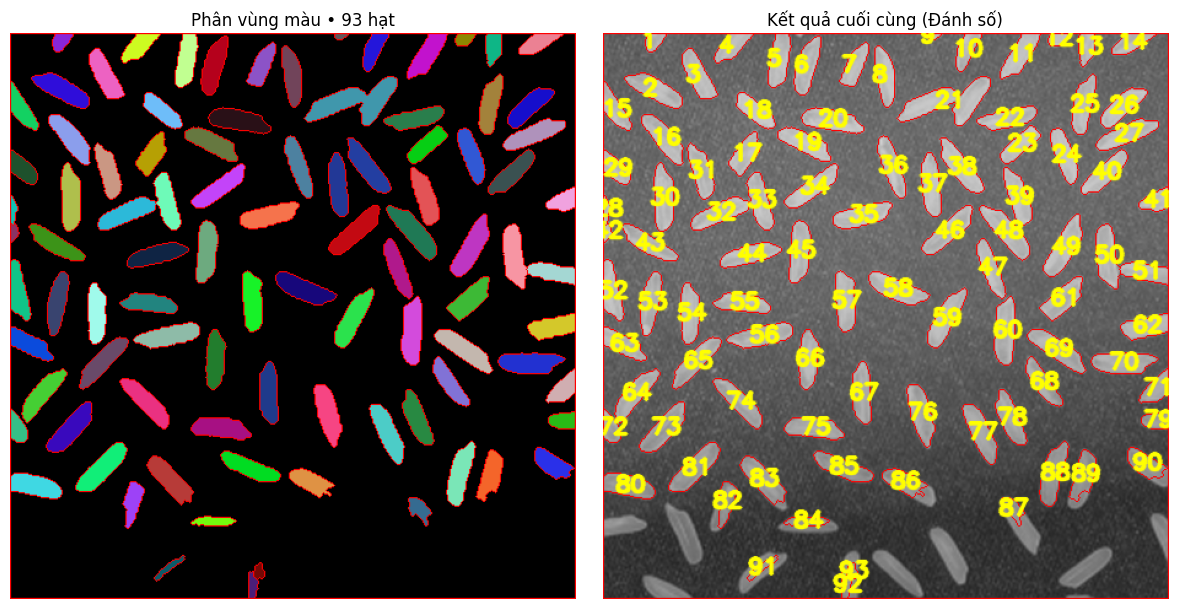

In [ ]:
# Đường dẫn ảnh
img_path = path_folder + "1_wIXlvBeAFtNVgJd49VObgQ.png"

# Gọi hàm
markers, rice_count = process_full_pipeline(img_path)

🔍 Phân loại ảnh: [ Standard ]
 -> Chạy mặc định...


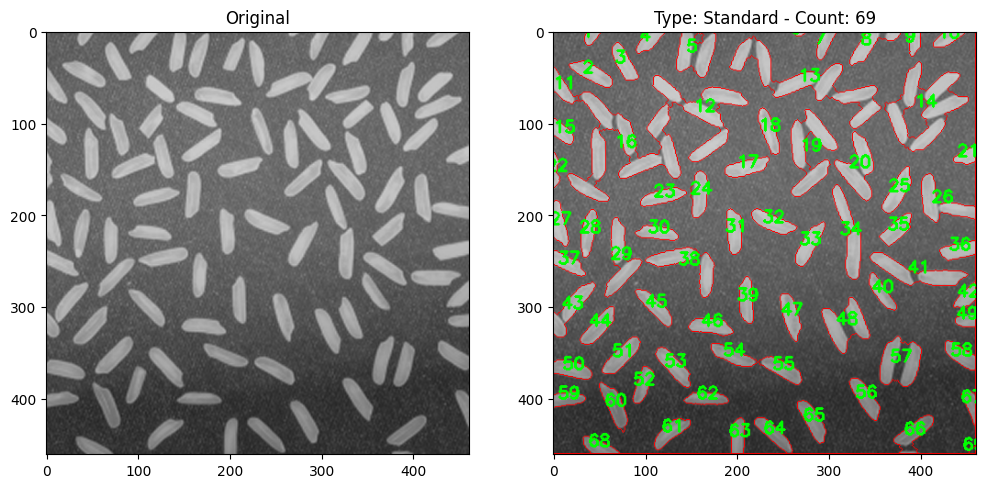

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


# ================= 1. CÁC HÀM CÔNG CỤ (DEFINITIONS) =================

def load_image(path):
    """Đọc ảnh hỗ trợ đường dẫn tiếng Việt"""
    p = Path(path)
    if not p.exists(): return None, None
    raw = cv2.imdecode(np.fromfile(str(p), dtype=np.uint8), cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
    return raw, gray


def classify_img(img_gray):
    """Phân loại ảnh để đưa ra quyết định xử lý"""
    # a. Ảnh tối
    if np.mean(img_gray) < 30: return "Dark"

    # b. Nhiễu muối tiêu (so sánh ảnh gốc với ảnh làm mượt)
    if np.mean(cv2.absdiff(img_gray, cv2.medianBlur(img_gray, 3))) > 8: return "Salt_Pepper"

    # c. Nhiễu sọc (Sinus) bằng FFT 1D
    proj = np.mean(img_gray, axis=0)
    spec = np.abs(np.fft.fft(proj - np.mean(proj)))[1:len(proj) // 2]
    if np.max(spec) / (np.mean(spec) + 1e-9) > 50: return "Sinus"

    # d. Mặc định
    return "Standard"


def apply_fft_notch(img_gray, D0=2, centers=[(0, 8), (0, -8)]):
    """Lọc nhiễu sọc bằng Fourier"""
    f = np.fft.fft2(img_gray)
    fshift = np.fft.fftshift(f)
    h, w = img_gray.shape
    y, x = np.ogrid[:h, :w]
    cy, cx = h // 2, w // 2

    mask = np.ones((h, w), dtype=np.float32)
    for (my, mx) in centers:  # my, mx: khoảng cách từ tâm
        # Tạo 2 lỗ đen đối xứng qua tâm
        for sign in [1, -1]:
            d2 = (y - (cy + sign * my)) ** 2 + (x - (cx + sign * mx)) ** 2
            mask *= (1 - np.exp(-0.5 * (d2 / (D0 ** 2))))

    fshift_filtered = fshift * mask
    img_back = np.fft.ifft2(np.fft.ifftshift(fshift_filtered))
    return cv2.normalize(np.abs(img_back), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


def enhance_contrast(img_gray, clahe_clip=2.0, use_median=False):
    """Tăng tương phản & Clean nền"""
    img = img_gray.copy()
    if use_median:
        img = cv2.medianBlur(img, 5)  # Khử nhiễu muối tiêu trước

    # Trừ nền (Flat field)
    bg = cv2.medianBlur(img, 81)
    diff = img.astype(np.float32) - bg.astype(np.float32)
    flat = cv2.normalize(diff, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(8, 8))
    out = clahe.apply(flat)
    return cv2.GaussianBlur(out, (3, 3), 0.5)

def enhance(img):
    # CLAHE giúp tăng tương phản trên nền nhiễu hạt
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    eq = clahe.apply(img)
    img = cv2.GaussianBlur(eq, (3,3), 0)
    return img



def binarize(img_enhanced, shift=-30):
    """Phân ngưỡng Otsu có dịch chuyển (shift)"""
    # Blur nhẹ để Otsu ổn định
    blur = cv2.GaussianBlur(img_enhanced, (0, 0), 1.2)
    val, _ = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Dịch ngưỡng
    new_thresh = np.clip(val + shift, 0, 255)
    _, th = cv2.threshold(blur, new_thresh, 255, cv2.THRESH_BINARY)

    # Đảo màu nếu nền trắng
    border_mean = np.mean(np.concatenate([th[0, :], th[-1, :], th[:, 0], th[:, -1]]))
    if border_mean > 127: th = cv2.bitwise_not(th)

    # Lấp lỗ trong hạt
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    return cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=2)


def morph_clean(binary_img):
    """Làm sạch và nối liền"""
    k_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    opened = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, k_open, iterations=1)

    k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, k_close, iterations=2)
    return closed


def split_watershed(binary_img, raw_img_color):
    """Tách hạt dính nhau"""
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    sure_fg = cv2.erode(binary_img, k, iterations=1)
    sure_bg = cv2.dilate(binary_img, k, iterations=1)
    unknown = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers.astype(np.int32) + 1
    markers[unknown == 255] = 0

    markers = cv2.watershed(raw_img_color, markers)
    return markers


def visualize(raw, markers, title="Result"):
    """Vẽ kết quả đếm"""
    overlay = raw.copy()
    labels = [lab for lab in np.unique(markers) if lab > 1]

    centroids = []
    for lab in labels:
        ys, xs = np.where(markers == lab)
        if len(xs) > 0:
            centroids.append((lab, int(np.mean(xs)), int(np.mean(ys))))

    centroids.sort(key=lambda c: (c[2] // 50, c[1]))

    overlay[markers == -1] = [0, 0, 255]  # Biên đỏ
    for idx, (_, cx, cy) in enumerate(centroids, 1):
        cv2.putText(overlay, str(idx), (cx - 10, cy),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1);
    plt.imshow(cv2.cvtColor(raw, cv2.COLOR_BGR2RGB));
    plt.title("Original")
    plt.subplot(1, 2, 2);
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB));
    plt.title(f"{title} - Count: {len(labels)}")
    plt.show()


# ================= 2. PIPELINE XỬ LÝ (LOGIC CHÍNH) =================

def process_pipeline(img_path):
    # 1. Load ảnh
    raw, gray = load_image(img_path)
    if raw is None: print("Lỗi load ảnh"); return

    # 2. Phân loại ảnh
    img_type = classify_img(gray)
    print(f"🔍 Phân loại ảnh: [ {img_type} ]")

    # 3. ĐIỀU HƯỚNG XỬ LÝ (IF - ELSE)
    enhanced = None
    binary = None

    if img_type == "Sinus":
        # -> Quy trình cho ảnh sọc
        print(" -> Chạy khử sọc FFT...")
        fft_cleaned = apply_fft_notch(gray)
        enhanced = enhance_contrast(fft_cleaned)
        binary = binarize(enhanced, shift=-30)

    elif img_type == "Dark":
        # -> Quy trình cho ảnh tối
        print(" -> Chạy tăng sáng mạnh...")
        # Tăng clahe_clip lên 5.0 để kéo sáng
        enhanced = enhance_contrast(gray, clahe_clip=5.0)
        # Shift thấp hơn (-40) để giữ lại nhiều chi tiết
        binary = binarize(enhanced, shift=-40)

    elif img_type == "Salt_Pepper":
        # -> Quy trình cho ảnh nhiễu hạt
        print(" -> Chạy khử nhiễu Median...")
        enhanced = enhance_contrast(gray, use_median=True)
        binary = binarize(enhanced, shift=-25)

    else:  # Standard
        # -> Quy trình mặc định
        print(" -> Chạy mặc định...")
        enhanced = enhance_contrast(gray)
        binary = binarize(enhanced, shift=-30)

    # 4. Các bước chung (Morphology + Watershed)
    morphed = morph_clean(binary)
    markers = split_watershed(morphed, raw)

    # 5. Hiển thị
    visualize(raw, markers, title=f"Type: {img_type}")


# ================= 3. CHẠY THỬ =================
folder = r"D:/OneDrive/Ca nhan/Study/Hoc thac si/GenAI - Dai hoc Bach khoa/0. Bo sung kien thuc/5. Thi giac may tinh (IT5409 - Nguyen Thi Oanh)/Bai tap nhom/Proj1.2/Proj1.2/"
img_name = "1_wIXlvBeAFtNVgJd49VObgQ.png"

# Gọi 1 hàm duy nhất
process_pipeline(folder + img_name)